In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import time, random
import seaborn as sns
from PIL import Image,ImageDraw
sns.set_style('darkgrid')

In [5]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [44]:
def create_dense_ae(latent_dim): # объявляем функцию создания автокодировщика
    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)    
    # Кодированное полносвязным слоем представление
    encoded = Dense(latent_dim, activation='relu')(flat_img)    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(latent_dim,)) # задаем входную размерность (49,)
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded) # далее полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(flat_decoded) # меняем форму, приводим к нужным нам размерам
    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")    
    decoder = Model(input_encoded, decoded, name="decoder")    
    # Построим модель автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder # функция вернет 3 собранные сетки

In [3]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [4]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [28]:
# Загрузим данные из fashion_mnist - базы с одеждой,обувью и т.п
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()
xTrainMnistF = xTrainMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размера
xTestMnistF = xTestMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1
xTestMnistF = xTestMnistF.reshape(xTestMnistF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размер

In [11]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаем автокодировщик

C:\Users\xande\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [52]:
# Обучаем модель автокодировщика
history = modelAutoMnist.fit(xTrainMnistF, xTrainMnistF, epochs=100, batch_size=256, validation_data = (xTestMnistF, xTestMnistF))

Epoch 1/100
235/235 [==============================] - 12s 48ms/step - loss: 7.8827e-04 - val_loss: 0.1873
Epoch 2/100
235/235 [==============================] - 10s 42ms/step - loss: 7.7657e-04 - val_loss: 0.1878
Epoch 3/100
235/235 [==============================] - 9s 40ms/step - loss: 7.7206e-04 - val_loss: 0.1872
Epoch 4/100
235/235 [==============================] - 9s 40ms/step - loss: 7.7040e-04 - val_loss: 0.1873
Epoch 5/100
235/235 [==============================] - 9s 40ms/step - loss: 7.7581e-04 - val_loss: 0.1875
Epoch 6/100
235/235 [==============================] - 9s 40ms/step - loss: 7.6539e-04 - val_loss: 0.1876
Epoch 7/100
235/235 [==============================] - 10s 41ms/step - loss: 7.6038e-04 - val_loss: 0.1876
Epoch 8/100
235/235 [==============================] - 10s 41ms/step - loss: 7.5768e-04 - val_loss: 0.1873
Epoch 9/100
235/235 [==============================] - 10s 41ms/step - loss: 7.5855e-04 - val_loss: 0.1874
Epoch 10/100
235/235 [===================

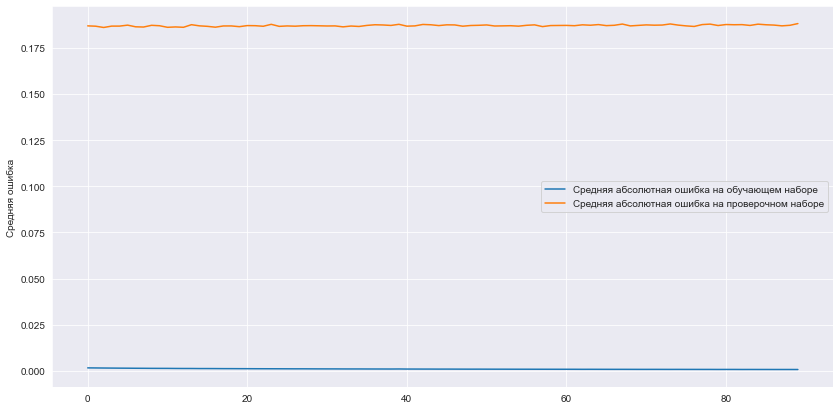

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [20]:
modelAutoMnist.save_weights('./modelAutoMnist.h5') # Сохраняем модель
modelAutoMnist.load_weights('./modelAutoMnist.h5') # Загружаем модель

In [49]:
predMnistF = modelAutoMnist.predict(xTrainMnistF) # сделаем предикт для первых ста картинок из fashion_mnist
predMnistF = predMnistF * 255 # представляем в виде значений от 0 до 255
predMnistF = predMnistF.astype('uint8') # устанавливаем 8битовый тип


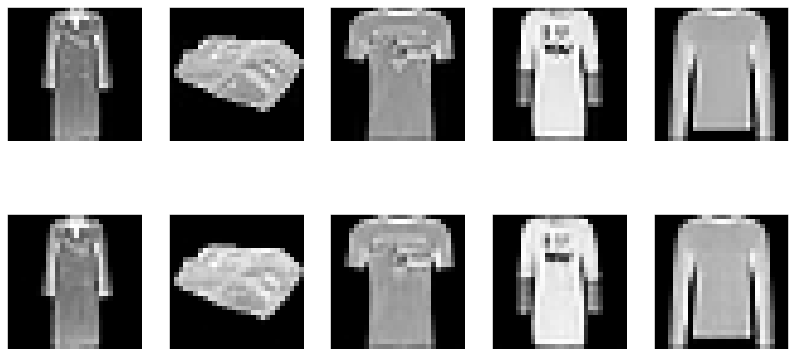

In [50]:
plotImages(xTrainMnistF, predMnistF, shape=(28,28)) # выведем на экран картинки правильных и восстановленных изображений 

In [41]:
def addSquare(x): # объявим функцию добавления квадрата
  
  squareRandomX = np.random.randint(20) # создаем координату Х квадрата
  squareRandomY = np.random.randint(20) # создаем координату Y квадрата

  for i in range(squareRandomX,squareRandomX+8):
    for j in range(squareRandomY,squareRandomY+8):
          x_copy = x.copy()
          x_copy[i][j] = 0
         
  return x_copy

def Any10Images(startIndex, xTrain):                  #Функция отображения любых 10 картинок
    n = 10
    plt.figure(figsize=(10,4))
    for i in range(n):
      index = i + startIndex
      ax = plt.subplot(2,n,i+1)
      plt.imshow(xTrain[index].reshape(28,28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    plt.show()

In [42]:
(xSquareMnist, ySquareMnist), (xSquareTestMnist, ySquareTestMnist) = fashion_mnist.load_data()

In [43]:
for i in range(0,12000):                                                        #Добавляем квадрат на выбранные картинки
  xSquareMnist[i] = addSquare(xSquareMnist[i])

Any10Images(1000,xSquareMnist)

TypeError: 'WRITEABLE' is an invalid keyword argument for setflags()